In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import pandas as pd
import numpy as np
import torch
import datetime
from tqdm import tqdm_notebook
from torch import nn
from torchvision import transforms
from cnn_finetune import make_model

import model2 as M
import unet_parts
from dataset import SegmentationDataset, SegmentationInferenceDataset
from data import *
from util import *
from loss import FocalLoss
from lovasz_loss import lovasz_hinge_flat

In [3]:
torch.cuda.is_available()
device = torch.device('cuda')

# Setup Dataset

In [4]:
train_df, val_df, _ = get_dfs()

In [5]:
train_dataset = SegmentationDataset(train_df, size=(128, 128),
                                    use_depth_channels=True, with_aux_label=True)
val_dataset = SegmentationInferenceDataset(val_df, input_size=(128, 128),
                                           use_depth_channels=True, with_aux_label=False, with_gt=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

# Training

In [6]:
gc.collect()
torch.cuda.empty_cache()

weight = torch.load(str(model_dir / 'unet_res34_hcaux_lovaszloss_ft_dict.model'))
model = M.UNetRes34HcAux(n_classes=1)
model.load_state_dict(weight)
model = model.to(device)

#criterion = lovasz_hinge_flat
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

Loaded pretrained resnet weights


In [7]:
def criterion(logit_pixel, logit_feat, target_pixel, target_label):
    pixel_loss = lovasz_hinge_flat(logit_pixel.view(-1), target_pixel.view(-1))
    classification_loss = F.cross_entropy(logit_feat, target_label)
    
    return pixel_loss + 0.1 * classification_loss

In [8]:
def train(model, n_epoch, train_iter, val_iter):
    for epoch in range(n_epoch):
        model.train()
        
        gc.collect()
        torch.cuda.empty_cache()
        
        total_loss = 0
        total_size = 0
        
        for batch_idx, (data, target, label) in enumerate(train_iter):
            data, target, label = data.to(device), target.to(device), label.to(device)
            optimizer.zero_grad()
            
            # Forward
            logit_pixel, logit_feat = model(data)
            loss = criterion(logit_pixel, logit_feat, target, label)
            
            total_loss += loss.item()
            total_size += data.size(0)
            
            # Backward
            loss.backward()
            optimizer.step()
            
            if batch_idx % 50 == 0:
                now = datetime.datetime.now()
                print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                    now,
                    epoch, batch_idx * len(data), len(train_iter.dataset),
                    100. * batch_idx / len(train_iter), total_loss / total_size))
                
        gc.collect()
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            iou = evaluate(model, val_iter, device=device, use_sigmoid=False, threshold=0.0)
            #iou = evaluate(model, val_iter, device=device, use_sigmoid=True, threshold=0.5)
        print('[{}] Train Epoch: {}\tIoU: {:.6f}'.format(now, epoch, iou))
    return model

In [9]:
model = train(model, 30, train_loader, val_loader)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


[2018-10-09 18:05:25.633033] Train Epoch: 0 [0/3200 (0%)]	Average loss: 0.004529
[2018-10-09 18:05:44.425868] Train Epoch: 0 [800/3200 (25%)]	Average loss: 0.009804
[2018-10-09 18:06:03.249559] Train Epoch: 0 [1600/3200 (50%)]	Average loss: 0.009094
[2018-10-09 18:06:22.112530] Train Epoch: 0 [2400/3200 (75%)]	Average loss: 0.008953
[2018-10-09 18:06:22.112530] Train Epoch: 0	IoU: 0.781500
[2018-10-09 18:06:57.003790] Train Epoch: 1 [0/3200 (0%)]	Average loss: 0.006657
[2018-10-09 18:07:16.277200] Train Epoch: 1 [800/3200 (25%)]	Average loss: 0.008855
[2018-10-09 18:07:35.551436] Train Epoch: 1 [1600/3200 (50%)]	Average loss: 0.008726
[2018-10-09 18:07:54.837455] Train Epoch: 1 [2400/3200 (75%)]	Average loss: 0.008455
[2018-10-09 18:07:54.837455] Train Epoch: 1	IoU: 0.782625
[2018-10-09 18:08:22.279612] Train Epoch: 2 [0/3200 (0%)]	Average loss: 0.011649
[2018-10-09 18:08:41.551254] Train Epoch: 2 [800/3200 (25%)]	Average loss: 0.007790
[2018-10-09 18:09:00.865120] Train Epoch: 2 [1600

[2018-10-09 18:34:55.739179] Train Epoch: 20 [2400/3200 (75%)]	Average loss: 0.007938
[2018-10-09 18:34:55.739179] Train Epoch: 20	IoU: 0.774250
[2018-10-09 18:35:23.332426] Train Epoch: 21 [0/3200 (0%)]	Average loss: 0.005055
[2018-10-09 18:35:42.667576] Train Epoch: 21 [800/3200 (25%)]	Average loss: 0.007615
[2018-10-09 18:36:01.967784] Train Epoch: 21 [1600/3200 (50%)]	Average loss: 0.007761
[2018-10-09 18:36:21.282523] Train Epoch: 21 [2400/3200 (75%)]	Average loss: 0.007784
[2018-10-09 18:36:21.282523] Train Epoch: 21	IoU: 0.775875
[2018-10-09 18:36:48.722893] Train Epoch: 22 [0/3200 (0%)]	Average loss: 0.007112
[2018-10-09 18:37:08.079730] Train Epoch: 22 [800/3200 (25%)]	Average loss: 0.007200
[2018-10-09 18:37:27.380847] Train Epoch: 22 [1600/3200 (50%)]	Average loss: 0.007729
[2018-10-09 18:37:46.716836] Train Epoch: 22 [2400/3200 (75%)]	Average loss: 0.007582
[2018-10-09 18:37:46.716836] Train Epoch: 22	IoU: 0.772500
[2018-10-09 18:38:14.103135] Train Epoch: 23 [0/3200 (0%)]	

In [10]:
save_model(model, 'unet_res34_hcaux_lovaszloss_ft_lr0001')

In [11]:
val_check_dataset = SegmentationInferenceDataset(val_df, input_size=(128, 128), with_gt=True, with_raw_input=True, use_depth_channels=True)
val_check_loader = torch.utils.data.DataLoader(val_check_dataset, batch_size=8, shuffle=False)
val_check_iter = iter(val_check_loader)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


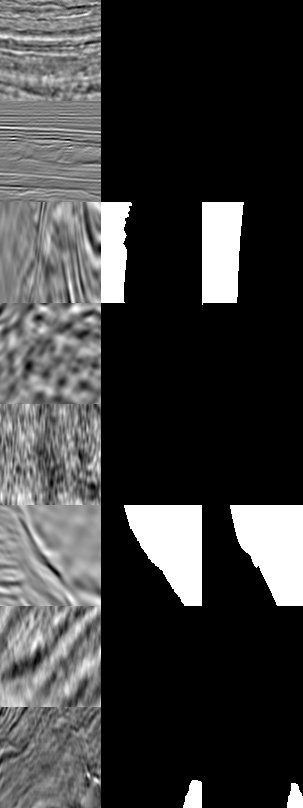

In [12]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


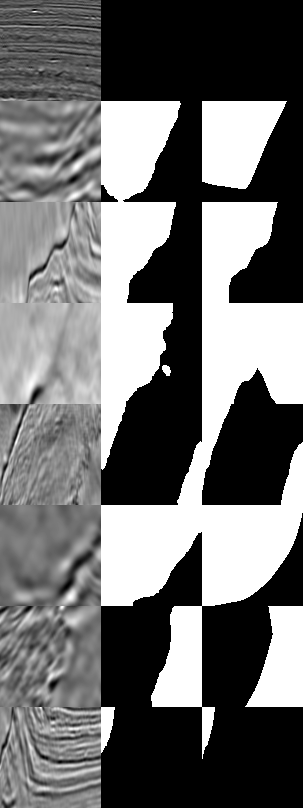

In [13]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


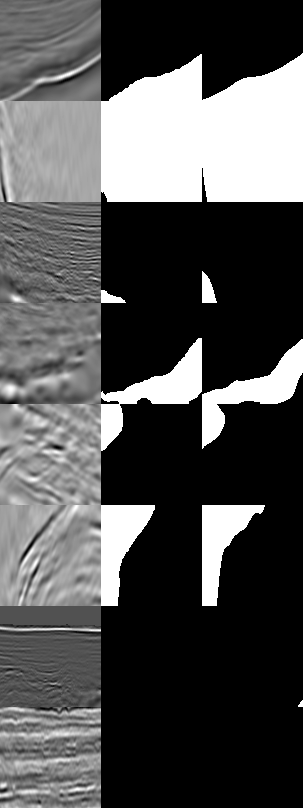

In [14]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)

D:\Users\ns\Anaconda3\envs\chainer\lib\site-packages\torch\nn\functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


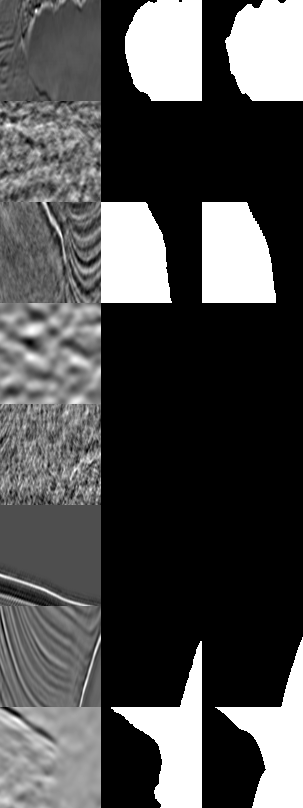

In [15]:
model.eval()
im, x, t = next(val_check_iter)
pred = predict(model, x, device, with_tta=True, use_sigmoid=False, threshold=0.0)
show_prediction(im, pred, t)